# Exploration of Medicare Class D Opiate Prescribers and U.S. Overdoses by State

#### Sourced from Kaggle user Alan (AJ) Pryor, Jr.: https://www.kaggle.com/apryor6/us-opiate-prescriptions

### Here is a brief description of the data from the page: 

"This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. This is a small subset of data that was sourced from cms.gov. The full dataset contains almost 24 million prescription instances in long format."

In short, the **prescriber-info** csv file contains a sample of U.S. Medicare prescribers and their prescriptions for 2014 and the **overdoses** file contains the number of opiate-related overdoses by state for 2014. 

#### Since both datasets contain information on U.S. states, I wanted to ask: **Does the number of opiate prescribers in a state correlate to the number of overdoses in that state?**

One thing to keep in mind: The number of prescribers in this dataset only accounts for the number of **Medicare Class D** prescribers. That means, these are practitioners who are writing scripts for patients who are 65 years or older OR are under 65 with a disability (and are eligible to receive Social Security Disability Insurance (SSDI) benefits). Therefore, just initially generalizing, this patient population may be "justified" in their prescription use of opiates for health reasons (and may not necessarily be those abusing opiates/ most vulnerable to overdose). With that in mind, let's see. 

In [2]:
import pandas
import plotly.plotly as plotly
import plotly.tools as tls
tls.set_credentials_file(username='*********', api_key='**********')

In [3]:
#import data
overdoses = pandas.read_csv("overdoses.csv")
prescriber_info = pandas.read_csv("prescriber-info.csv")

In [4]:
#Data Cleaning for Prescribers

#Isolate the opiate prescribers count by state
state_opiate_prescribers = prescriber_info[prescriber_info["Opioid.Prescriber"] == 1]['State'].value_counts()

#extract list of state name abbreviations from the 'overdoses' dataframe
abbrev = list(overdoses["Abbrev"])

#Remove US territories from the prescribers pandas series and convert to a dictionary
territories = list(set(state_opiate_prescribers.index)-set(abbrev))
state_opiate_prescribers = dict(state_opiate_prescribers.drop(territories, errors='ignore'))


In [5]:
#Isolate the state populations from 'overdose' df  
statePops = [x.replace(',', '') for x in overdoses["Population"]]

#Create dictionary with 2014 state populations
state_pop_dict = pandas.Series(data=statePops, index =abbrev).to_dict()


## Normalizing the number of opiate prescribers per state
I had to make a decision about how to normalize the prescriber data. I decided to divide the number of opiate prescribers in each state by the state's population, yielding a "per capita" percentage of prescribers. To me, this is the best measure of "how much access" patients have to opiate prescribers in that state, and could best provide information about overdoses.  

In [6]:
#Normalize the number of opiate prescribers in each state to the state population (expressed as a percentage)

norm_prescriber_dict = {}
for key in state_opiate_prescribers:
    if key in state_pop_dict.keys():
        ratio = (float(state_opiate_prescribers[key]) / float(state_pop_dict[key])) * 100
        norm_prescriber_dict[key] = ratio
        

In [7]:
#10 states with lowest percent of prescribers
import operator
sorted_ratio = sorted(norm_prescriber_dict.items(), key=operator.itemgetter(1)) #ascending order
print(sorted_ratio[:10])
#10 states with highest percent of prescribers
sorted_ratio_desc = sorted(norm_prescriber_dict.items(), key=operator.itemgetter(1), reverse=True) #descending order
print(sorted_ratio_desc[:10])



[('HI', 0.0033474495995168274), ('TX', 0.0035881468348329133), ('AK', 0.0036728097811005375), ('UT', 0.0036885460647694897), ('CA', 0.003813993866983077), ('NJ', 0.00386545562541218), ('NV', 0.0038707790587985676), ('IA', 0.0038829723894776625), ('GA', 0.003983119977878672), ('WY', 0.00411905440241102)]
[('ME', 0.007076703942326368), ('RI', 0.007037491761855083), ('WV', 0.006795002329715084), ('VT', 0.006383352217416976), ('CT', 0.005617227647883251), ('MI', 0.005598435348480368), ('OR', 0.0055978717909245775), ('MA', 0.005513367750294942), ('TN', 0.0055111024082901755), ('DE', 0.005509052669784143)]


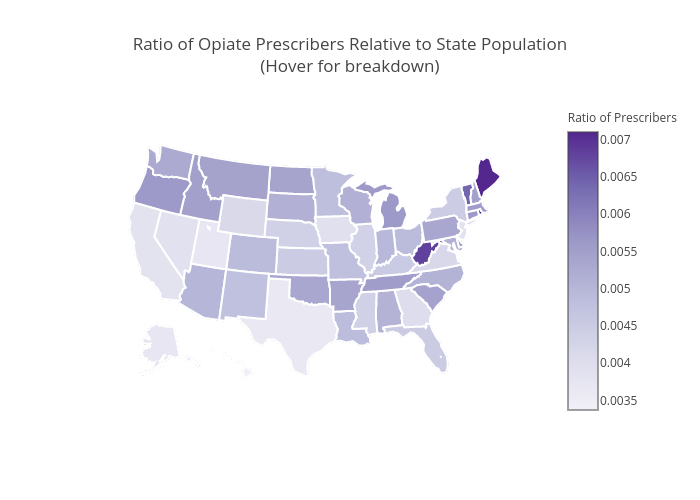

In [9]:
#Plotting the prescriber data on a chloropleth map


#Convert normalized prescriber info back into a df for plotting in plotly
opiates_normed = pandas.DataFrame.from_dict(norm_prescriber_dict, orient='index')
        
opiates_normed['State'] = opiates_normed.index
opiates_normed['Ratio'] = opiates_normed[0]

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
           [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

for col in opiates_normed.columns:
    opiates_normed[col] = opiates_normed[col].astype(str)
    
opiates_normed['text'] = opiates_normed['State'] + '<br>' +\
    'Ratio: '+ opiates_normed['Ratio']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = opiates_normed['State'],
        z = opiates_normed['Ratio'].astype(float),
        locationmode = 'USA-states',
        text = opiates_normed['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Ratio of Prescribers ")
        ) ]


layout = dict(
        title = 'Ratio of Opiate Prescribers Relative to State Population<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.iplot( fig, filename='opiate-prescribers-map' )

plotly.image.save_as(fig, filename='opiate-prescribers-map.png')

from IPython.display import Image
Image('opiate-prescribers-map.png')



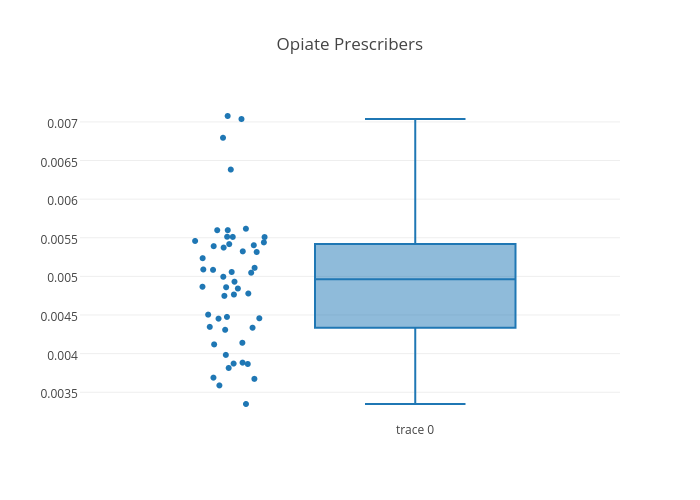

In [11]:
#boxplot of the number of opiate prescribers
from plotly.graph_objs import *

prescribers_state = {
  "y": opiates_normed['Ratio'],
  "boxpoints": "all", 
  "jitter": 0.5, 
  "pointpos": -1.8, 
  "type": "box"
  
}

data = Data([prescribers_state])
layout = {
  "showlegend": False, 
  "title": "Opiate Prescribers", 
  "xaxis": {
    "showgrid": False, 
    "showline": False, 
    "ticks": ""
  }, 
  "yaxis": {
    "showline": False, 
    "ticks": "", 
    "zeroline": False
  }
    
}
fig = Figure(data=data, layout=layout)
plotly.iplot( fig, filename='opiate_prescribers_boxplot' )

plotly.image.save_as(fig, filename='opiate_prescribers_boxplot.png')

from IPython.display import Image
Image('opiate_prescribers_boxplot.png')

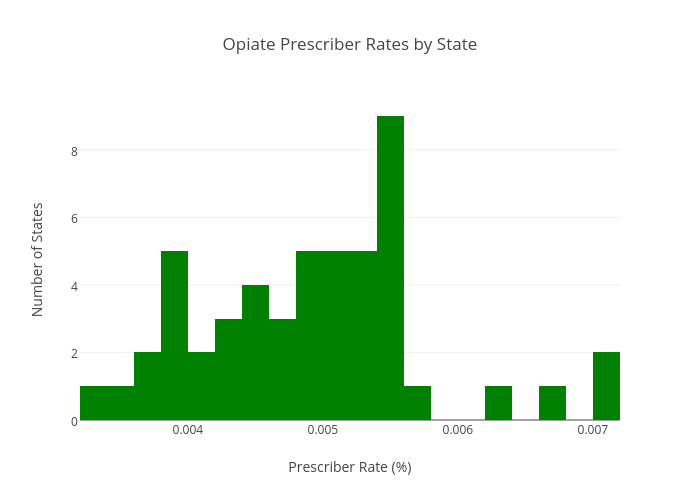

In [12]:
#Histogram of opiate prescribers
import plotly.graph_objs as go

x = opiates_normed['Ratio']

data = [go.Histogram(
        x=x,
        histnorm='count',
        nbinsx=20,
        marker=dict(
            color='green'),
        )]

layout = go.Layout(
    title='Opiate Prescriber Rates by State',
    xaxis=dict(
        title='Prescriber Rate (%)'
    ),
    yaxis=dict(
        title='Number of States'
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.iplot(fig)

plotly.image.save_as(fig, filename='opiate_prescribers_hist.png')

from IPython.display import Image
Image('opiate_prescribers_hist.png')

From the chlorpleth map, boxplot, and histogram, it is clear there are 4 states (Maine, Rhode Island, Vermont, and West Virginia) that have very high rates of opiate prescribers per capita. Does this translate to high rates of opiate-related overdoses?






## Normalized Overdoses in each State to Their Population

In [13]:
#Decided to convert Series to lists in order to make this normalized count
deaths = []
for row in overdoses["Deaths"]:
    row = float(row.replace(",",""))
    deaths.append(row)
#overdoses["Deaths"] = pandas.Series(deaths)

population = []
for row in overdoses["Population"]:
    row = float(row.replace(",",""))
    population.append(row)
#overdoses["Population"] = pandas.Series(population)

abbrev = []
for row in overdoses["Abbrev"]:
    abbrev.append(row)
    
od_ratio_dict = {}
for i, row in enumerate(deaths):
    key = abbrev[i]
    ratio = deaths[i] / population[i] *100
    od_ratio_dict[key] = ratio

In [14]:
#10 states with lowest percent of overdoses
import operator
sorted_ratio = sorted(od_ratio_dict.items(), key=operator.itemgetter(1)) #ascending order
print(sorted_ratio[:10])
#10 states with highest percent of overdoses
sorted_ratio_desc = sorted(od_ratio_dict.items(), key=operator.itemgetter(1), reverse=True) #descending order
print(sorted_ratio_desc[:10])


[('ND', 0.0059442101319752885), ('NE', 0.006689800890118148), ('SD', 0.007456706715888821), ('IA', 0.008542539256850857), ('MN', 0.009538076666211594), ('TX', 0.00983432025015849), ('HI', 0.011181906109024297), ('MS', 0.011232923699362832), ('KS', 0.011472181514790994), ('NY', 0.011704163328647767)]
[('WV', 0.0338132258788203), ('NM', 0.026231401241172077), ('NH', 0.02523689815853759), ('KY', 0.024503474738328146), ('OH', 0.02371485206564658), ('RI', 0.023490006286191967), ('PA', 0.021387525921219532), ('UT', 0.020786853056598154), ('DE', 0.020415901070376528), ('OK', 0.020178841147591733)]


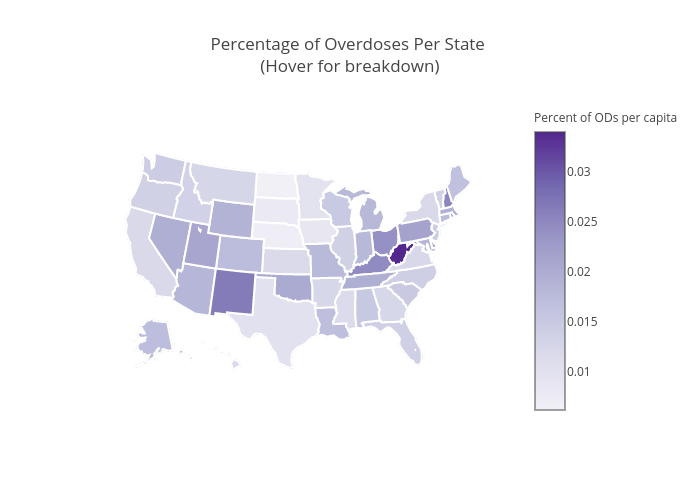

In [15]:
#Plotting overdoses on chloropleth map

#convert dict to df
overdoses_normed = pandas.DataFrame.from_dict(od_ratio_dict, orient='index')
        
overdoses_normed['State'] = overdoses_normed.index
overdoses_normed['Overdose Percentage'] = overdoses_normed[0]

for col in overdoses_normed.columns:
    overdoses_normed[col] = overdoses_normed[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


overdoses_normed['text'] = overdoses_normed['State'] + '<br>' +\
    'Overdoses: '+ overdoses_normed['Overdose Percentage']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = overdoses_normed['State'],
        z = overdoses_normed['Overdose Percentage'].astype(float),
        locationmode = 'USA-states',
        text = overdoses_normed['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Percent of ODs per capita ")
        ) ]


layout = dict(
        title = 'Percentage of Overdoses Per State <br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
plotly.iplot( fig, filename='overdoses_map' )


plotly.image.save_as(fig, filename='overdoses_map.png')

from IPython.display import Image
Image('overdoses_map.png')


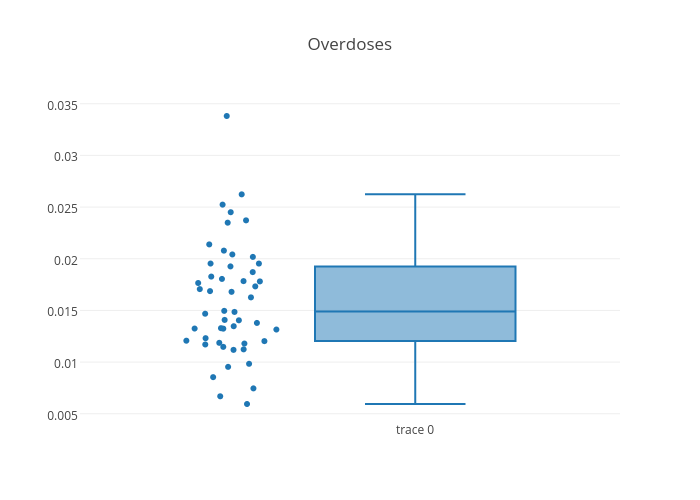

In [16]:
#Make a boxplot of the number of overdoses
from plotly.graph_objs import *

overdoses = {
  "y": overdoses_normed['Overdose Percentage'],
  "boxpoints": "all", 
  "jitter": 0.5, 
  "pointpos": -1.8, 
  "type": "box"
}

data = Data([overdoses])
layout = {
  "showlegend": False, 
  "title": "Overdoses", 
  "xaxis": {
    "showgrid": False, 
    "showline": False, 
    "ticks": ""
  }, 
  "yaxis": {
    "showline": False, 
    "ticks": "", 
    "zeroline": False
  }
}
fig = Figure(data=data, layout=layout)
plotly.iplot( fig, filename='overdose_boxplot' )

plotly.image.save_as(fig, filename='overdoses_boxplot.png')

from IPython.display import Image
Image('overdoses_boxplot.png')

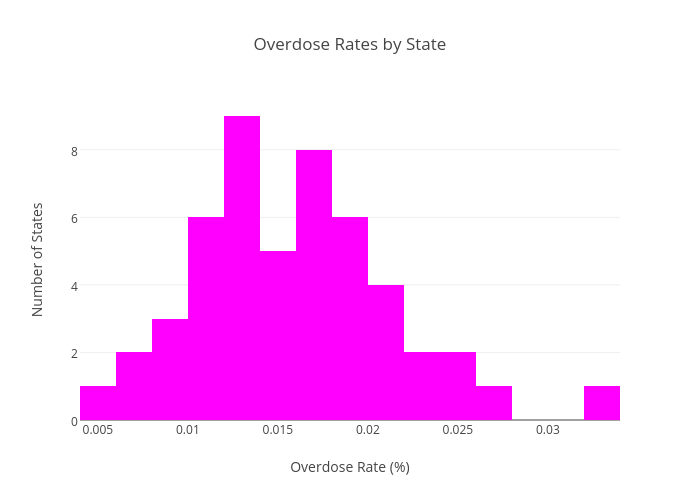

In [17]:
#Histogram of overdoses
import plotly.graph_objs as go

x = overdoses_normed['Overdose Percentage']

data = [go.Histogram(
        x=x,
        histnorm='count',
        nbinsx=20,
        marker=dict(
            color='fuchsia'),
        )]

layout = go.Layout(
    title='Overdose Rates by State',
    xaxis=dict(
        title='Overdose Rate (%)'
    ),
    yaxis=dict(
        title='Number of States'
    )
)
fig = go.Figure(data=data, layout=layout)
plotly.iplot(fig)

plotly.image.save_as(fig, filename='overdoses_hist.png')

from IPython.display import Image
Image('overdoses_hist.png')

# Conclusions

When looking at the overdose plots, the state with the highest rate of OD is West Virginia, which also had one of the highest rates of opiate prescribers per capita. Based on cursory comparison, it seems none of the other states had quite a high correlation between number of prescribers and number of overdoses. In the case of West Virginia, where these two variables seem to be very highly correlated, you could potentially consider that the population of people overdosing on opiates in that state are getting them from Medicare prescribers. 

Future directions: I'd like to do a more statistical analysis of the strength of the correlation between opiate prescriber rate and overdose rate by state to potentially draw more sound conclusions. 